In [1]:
from paraview.simple import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['figure.labelsize'] = 'large'
mpl.rcParams['font.size'] = 15
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['legend.markerscale'] = 1.0
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4.5
savefig_directory = '../Figures/'
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

In [ ]:
# Case files
angles = ['0.00000000000', '0.08715574274765817', '0.17364817766693033', '0.25881904510252074', '0.3420201433256687', '0.39073112848927377', '0.42261826174069944', '0.49999999999999994']
Theta = ['00', '05', '10', '15', '20', '23', '25', '30']
Point2_y = [0.00000000000, 0.08715574274765817, 0.17364817766693033, 0.25881904510252074, 0.3420201433256687, 0.39073112848927377, 0.42261826174069944, 0.49999999999999994]
folder = [f'src/turbulence_angle_value_{angle}/case.foam' for angle in angles]

# Properties of interest with geometry storage
properties = ['Ma', 'T', 'p', 'U', 'rho']
store_files = ['Ma.png', 'T.png', 'p.png', 'U.png', 'rho.png']

# Lineplot points
csv_files = [f'Figures/angle_value_{angle}/lineplot.csv' for angle in angles]

# Plotting settings
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

In [4]:
# Load your case.foam file
foamCase = [OpenFOAMReader(FileName=folder_) for folder_ in folder]

# Update pipeline to read the time steps, etc.
[foamCase_.UpdatePipeline() for foamCase_ in foamCase]

[None]

In [5]:
foamCase_ = foamCase[0]

hasattr(foamCase_, "TimestepValues")
final_time = foamCase_.TimestepValues[-1]

In [ ]:
def store_geometry(foamCase, property, store_file):
    # Create a geometry view and show the data
    renderView = GetActiveViewOrCreate('RenderView')
    SetActiveSource(foamCase)
    display = Show(foamCase, renderView)
    
    # If foamCase has multiple time steps, update to the final time step.
    if hasattr(foamCase, "TimestepValues"):# and foamCase.TimestepValues:
        # final_time = foamCase.TimestepValues[-1]
        # UpdatePipeline(time=final_time)
        final_time = foamCase_.TimestepValues[-1]
        GetAnimationScene().AnimationTime = final_time
        renderView.Update()

    # Set properties to color by the specified property
    ColorBy(display, ('POINTS', property))
    display.RescaleTransferFunctionToDataRange(True)
    display.SetScalarBarVisibility(renderView, True)

    # Set the color map for the specific property
    lut = GetColorTransferFunction(property)
    lut.ApplyPreset('Cool to Warm', True)
    display.SetRepresentationType('Surface')
    display.SetScalarBarVisibility(renderView, True)

    # Set the camera
    # Reset the camera to what would be the default in ParaView
    ResetCamera()
    # Apply camera parallel projection (orthographic view)
    renderView.CameraParallelProjection = 1
    # Show the orientation axes for better spatial reference
    renderView.OrientationAxesVisibility = 1
    # Set the background color to white
    renderView.Background = [1.0, 1.0, 1.0]
    # Set the view size
    LoadPalette('WhiteBackground')
    renderView.ViewSize = [600, 600]

    # Store a figure
    if store_file is not None:
        # Make sure directory exists before saving
        store_dir = os.path.dirname(store_file)
        if store_dir and not os.path.exists(store_dir):
            os.makedirs(store_dir, exist_ok=True)
        SaveScreenshot(store_file, renderView, magnification=2, quality=100)

    # Clean up
    Delete(display)
    Delete(renderView)

: 

In [ ]:
# Cutplots
os.makedirs('Figures', exist_ok=True)
# Loop over different geometries
for i, foamCase_ in tqdm(enumerate(foamCase)):
    # Set the active source to the current foamCase
    # Loop through each property and store the geometry
    store_file = f'Figures/angle_value_{angles[i]}'
    os.makedirs(store_file, exist_ok=True)
    # print(f'store_file: {store_file}')
    for property, store_file_ in zip(properties, store_files):
            store_file_ = f'{store_file}/{store_file_}'
            # print(f'store_file_: {store_file_}')
            store_geometry(foamCase_, property, store_file_)

0it [00:00, ?it/s]

In [ ]:
def store_lineplot(foamCase, Point1, Point2, store_file, convergence=False):
    """
    Extract data along a line between Point1 and Point2, and save it to a CSV file.
    
    Parameters:
    -----------
    foamCase: paraview.servermanager.OpenFOAMReader
        The OpenFOAM reader object to extract data from
    Point1: list
        The starting point coordinates [x, y, z]
    Point2: list
        The ending point coordinates [x, y, z]
    store_file: str
        Path to save the CSV file
    """
    # Retrieve data information
    dataInfo = foamCase.GetDataInformation()

    # Get the total number of points (nodes) and cells
    total_points = dataInfo.GetNumberOfPoints()
    total_cells = dataInfo.GetNumberOfCells()

    print("Total number of points:", total_points)
    print("Total number of cells:", total_cells)
    # Create a render view for the pipeline
    renderView = GetActiveViewOrCreate('RenderView')

    # If foamCase has multiple time steps, update to the final time step.
    if hasattr(foamCase, "TimestepValues"):# and foamCase.TimestepValues:
        # final_time = foamCase.TimestepValues[-1]
        # UpdatePipeline(time=final_time)
        final_time = foamCase_.TimestepValues[-1]
        GetAnimationScene().AnimationTime = final_time
        renderView.Update()
    
    # Extract properties along a line
    lineSource = PlotOverLine(Input=foamCase)
    lineSource.Point1 = Point1
    lineSource.Point2 = Point2
    lineDisplay = Show(lineSource, renderView)
    lineDisplay.UpdatePipeline()

    # Render the view
    Render()

    # Make sure directory exists before saving
    store_dir = os.path.dirname(store_file)
    if store_dir and not os.path.exists(store_dir):
        os.makedirs(store_dir, exist_ok=True)
    
    # Add file extension if not present
    if not store_file.endswith('.csv'):
        store_file = store_file + '/lineplot.csv'
    
    # Save the line plot
    SaveData(store_file, proxy=lineSource)

    # Clean up
    Delete(lineSource)
    Delete(lineDisplay)
    Delete(renderView)

    if convergence:
        return total_points, total_cells

In [ ]:
def plot_all_geometries(df, entry, angles, xlabel, ylabel, title, savefig=None, colors=colors):
    fig, axs = plt.subplots()
    for i, df_ in enumerate(df):
        xaxis = df_['Points:0'].values
        axs.plot(
            xaxis, df_[entry] / df_[entry].values[-1], 
            label=f'$\Theta$ = {Theta[i]}°', 
            color=colors[i]
        )
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    fig.suptitle(title)
    axs.legend()
    fig.tight_layout()
    if savefig is not None:
        fig.savefig(savefig, bbox_inches='tight')
    fig.show()

<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/3424711049.py:7: SyntaxWarning: invalid escape sequence '\T'
  label=f'$\Theta$ = {Theta[i]}°',


In [ ]:
# # Loop over different geometries
# for i, foamCase_ in tqdm(enumerate(foamCase)):
#     store_lineplot(foamCase_, Point1, Point2_vec[i], csv_files[i])

In [ ]:
# # Load the line plot data
# df = [pd.read_csv(csv_file) for csv_file in csv_files]

In [ ]:
store_lineplot(foamCase[0], [0, 0.5, 1], [2.5, 0.5, 1], 'rho_temp.csv')
df_rho = pd.read_csv('rho_temp.csv')
rho1 = df_rho['rho'].values[0]
os.remove('rho_temp.csv')
print(f'rho1: {rho1}')

Total number of points: 21222
Total number of cells: 10400
rho1: 1.174


In [ ]:
# Inflow
M1 = 2.
T1 = 300.
p1 = 101325.

# True outflow
M2_true = [2, 1.852, 1.587, 1.486, 1.229, 0.917]
rho2rho1_true = [1, 1.201, 1.491, 1.714, 2.027, 2.379]
p2p1_true = [1, 1.293, 1.761, 2.167, 2.810, 3.667]
T2T1_true = [1, 1.077, 1.182, 1.264, 1.386, 1.541]

In [ ]:
# # Loop over different geometries
# EPS = 0.0001
# Point1_vec = [[1.5, 0, 1.0] for point2 in Point2_y]
# Point2_vec = [[2.5, point2+EPS, 1.0] for point2 in Point2_y]
# csv_files_shock = [f'Figures/angle_value_{angle}_shock/lineplot.csv' for angle in angles]
# csv_files_upstream = [f'Figures/angle_value_{angle}_upstream/lineplot.csv' for angle in angles]

# # Extract data for upstream and shock lines for each case
# for i, foamCase_ in tqdm(enumerate(foamCase)):
#     # Create directories if they don't exist
#     os.makedirs(f'Figures/angle_value_{angles[i]}_upstream', exist_ok=True)
#     os.makedirs(f'Figures/angle_value_{angles[i]}_shock', exist_ok=True)
    
#     # Extract upstream data for this angle
#     upstream_csv = csv_files_upstream[i]
#     store_lineplot(foamCase_, [0.0, 0.0, 1.0], [1.5, 0.0, 1.0], upstream_csv)
    
#     # Extract shock line data for this angle
#     store_lineplot(foamCase_, Point1_vec[i], Point2_vec[i], csv_files_shock[i])
    
# # Load the line plot data
# df_upstream = [pd.read_csv(csv_file) for csv_file in csv_files_upstream]
# df_shock_original = [pd.read_csv(csv_file) for csv_file in csv_files_shock]

# # Combine upstream data with shock data for each angle
# df_shock = []
# for i, (df_up, df_sh) in enumerate(zip(df_upstream, df_shock_original)):
#     # Combine the upstream and shock data for each case
#     df_shock_combined = pd.concat([df_up, df_sh], ignore_index=True)
#     df_shock.append(df_shock_combined)

In [ ]:
# Loop over different geometries
EPS = 0.0001
Point1_vec = [[0.0, point2+EPS, 1.0] for point2 in Point2_y]
Point2_vec = [[2.5, point2+EPS, 1.0] for point2 in Point2_y]
csv_files_shock = [f'Figures/angle_value_{angle}_shock/lineplot.csv' for angle in angles]
for i, foamCase_ in tqdm(enumerate(foamCase)):
    store_lineplot(foamCase_, Point1_vec[i], Point2_vec[i], csv_files_shock[i])
# Load the line plot data
df_shock = [pd.read_csv(csv_file) for csv_file in csv_files_shock]

1it [00:00,  9.17it/s]

Total number of points: 21222
Total number of cells: 10400
Total number of points: 29322
Total number of cells: 14400


2it [00:00,  8.97it/s]

Total number of points: 21222
Total number of cells: 10400


3it [00:00,  8.92it/s]

Total number of points: 29322
Total number of cells: 14400


5it [00:00,  8.15it/s]

Total number of points: 29322
Total number of cells: 14400
Total number of points: 121002
Total number of cells: 60000


6it [00:00,  7.35it/s]

Total number of points: 21222
Total number of cells: 10400


7it [00:00,  7.74it/s]

Total number of points: 21222
Total number of cells: 10400


8it [00:00,  8.14it/s]


In [ ]:
[print(f'Angle: {angle}, rho2/rho1: {df_["rho"].values[-1]/rho1}') for angle, df_ in zip(angles, df_shock)]

Angle: 0.00000000000, rho2/rho1: 1.0
Angle: 0.08715574274765817, rho2/rho1: 1.2123509369676322
Angle: 0.17364817766693033, rho2/rho1: 1.441993185689949
Angle: 0.25881904510252074, rho2/rho1: 1.66839863713799
Angle: 0.3420201433256687, rho2/rho1: 1.896763202725724
Angle: 0.39073112848927377, rho2/rho1: 2.08236797274276
Angle: 0.42261826174069944, rho2/rho1: 2.199744463373084
Angle: 0.49999999999999994, rho2/rho1: 2.4809199318568993


[None, None, None, None, None, None, None, None]

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\T'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/3031649140.py:15: SyntaxWarning: invalid escape sequence '\s'
  axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/3031649140.py:18: SyntaxWarning: invalid escape sequence '\T'
  [axs[0,0].plot([], [], color=colors[i], label=f'$\Theta$ = {Theta[i]}°') for i in range(7)]
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/3031649140.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


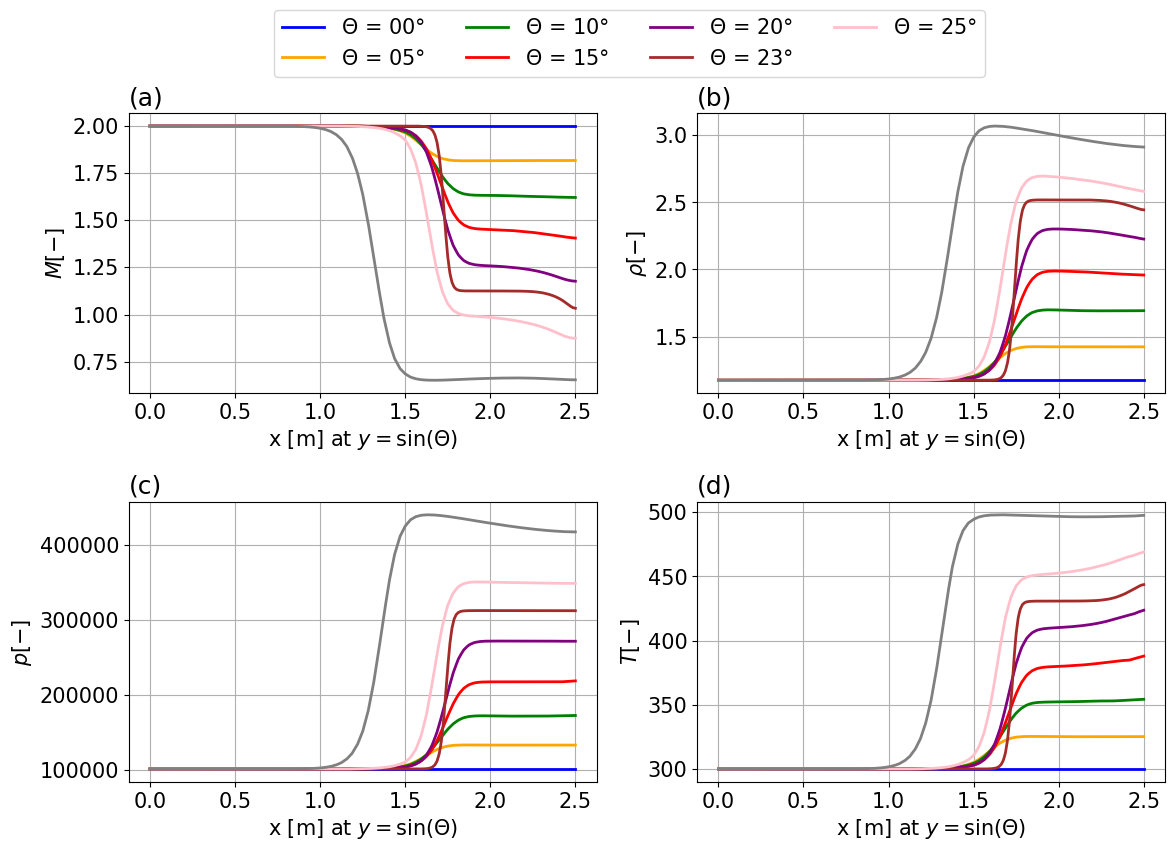

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
title = ['(a)', '(b)', '(c)', '(d)']
ylabels = ['$M [-]$', '$\\rho [-]$', '$p [-]$', '$T [-]$']
for enum, entry in enumerate(['Ma', 'rho', 'p', 'T']): 
    row, col = enum // 2, enum % 2
    for i, df_ in enumerate(df_shock):
        # if i >= 5:
        #     continue
        xaxis = df_['Points:0'].values
        axs[row, col].plot(
            xaxis, 
            df_[entry],#! / df_[entry].values[-1], 
            color=colors[i]
        )
    axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
    axs[row, col].set_ylabel(ylabels[enum])
    axs[row, col].set_title(title[enum], loc='left')
[axs[0,0].plot([], [], color=colors[i], label=f'$\Theta$ = {Theta[i]}°') for i in range(7)]
# Create a single legend for all subplots
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.84, 1.08), ncol=4)
fig.tight_layout()
fig.savefig('Figures/angle_value_lineplot.pdf', bbox_inches='tight')
fig.show()

<>:47: SyntaxWarning: invalid escape sequence '\T'
<>:47: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/2687790230.py:47: SyntaxWarning: invalid escape sequence '\T'
  axs[row, col].set_xlabel('$\Theta [°]$')


Comparison of Theoretical and Numerical Values for Different Shock Angles

Attached shock values 

 Angle   |  Property  | Theoretical  |  Numerical   | Error % 
--------------------------------------------------------
   00    |     M2     |    2.000     |    1.998     |   0.11  %
         | rho2/rho1  |    1.000     |    1.000     |   0.00  %
         |   p2/p1    |    1.000     |    1.000     |   0.00  %
         |   T2/T1    |    1.000     |    1.000     |   0.00  %
--------------------------------------------------------
   05    |     M2     |    1.852     |    1.816     |   1.97  %
         | rho2/rho1  |    1.201     |    1.212     |   0.95  %
         |   p2/p1    |    1.293     |    1.314     |   1.65  %
         |   T2/T1    |    1.077     |    1.084     |   0.66  %
--------------------------------------------------------
   10    |     M2     |    1.587     |    1.620     |   2.07  %
         | rho2/rho1  |    1.491     |    1.442     |   3.29  %
         |   p2/p1    |    

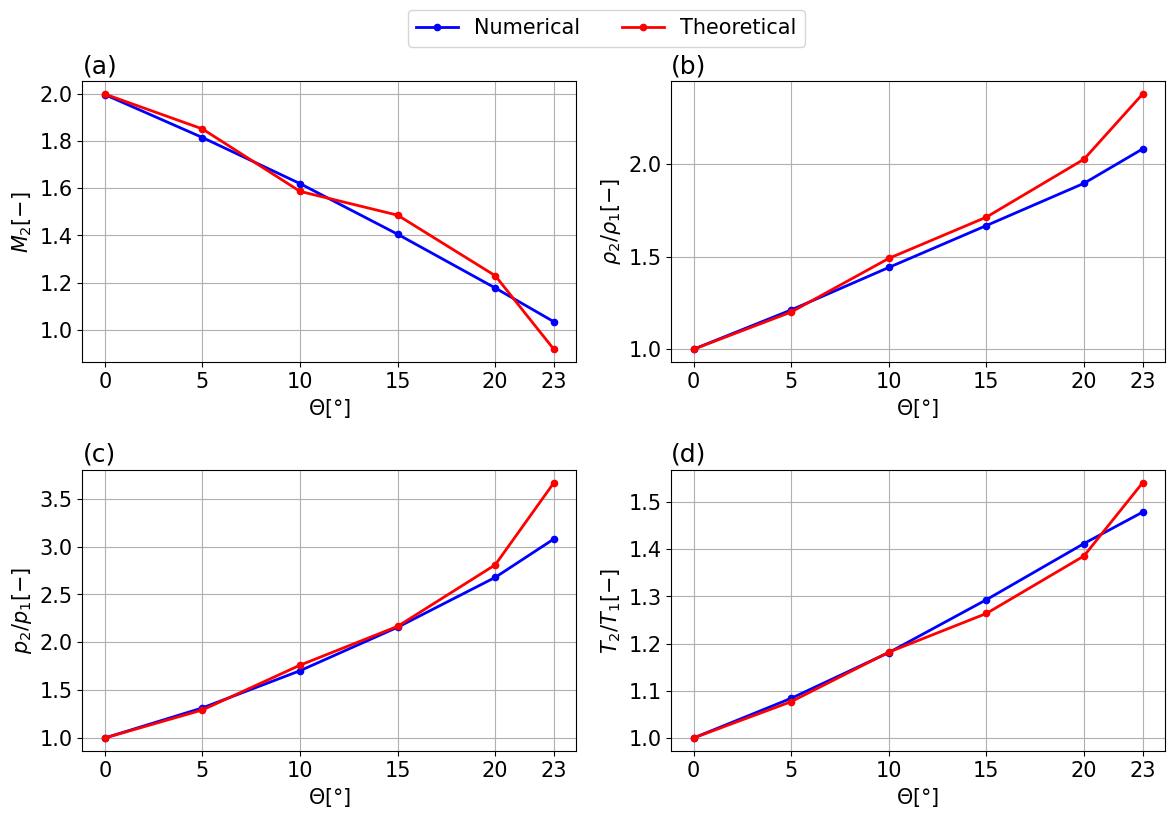

In [ ]:
M2 = np.array([df_['Ma'].values[-1] for df_ in df_shock])
rho2 = np.array([df_['rho'].values[-1] for df_ in df_shock])
p2 = np.array([df_['p'].values[-1] for df_ in df_shock])
T2 = np.array([df_['T'].values[-1] for df_ in df_shock])

# Create a formatted table comparing numerical vs theoretical values
print("Comparison of Theoretical and Numerical Values for Different Shock Angles\n")
print('Attached shock values \n')
print(f"{'Angle':^8} | {'Property':^10} | {'Theoretical':^12} | {'Numerical':^12} | {'Error %':^8}")
print("-" * 56)

for i in range(6):
    print(f"{Theta[i]:^8} | {'M2':^10} | {M2_true[i]:^12.3f} | {M2[i]:^12.3f} | {abs(M2[i]-M2_true[i])/M2_true[i]*100:^8.2f}%")
    print(f"{' ':^8} | {'rho2/rho1':^10} | {rho2rho1_true[i]:^12.3f} | {rho2[i]/rho1:^12.3f} | {abs(rho2[i]/rho1-rho2rho1_true[i])/rho2rho1_true[i]*100:^8.2f}%")
    print(f"{' ':^8} | {'p2/p1':^10} | {p2p1_true[i]:^12.3f} | {p2[i]/p1:^12.3f} | {abs(p2[i]/p1-p2p1_true[i])/p2p1_true[i]*100:^8.2f}%")
    print(f"{' ':^8} | {'T2/T1':^10} | {T2T1_true[i]:^12.3f} | {T2[i]/T1:^12.3f} | {abs(T2[i]/T1-T2T1_true[i])/T2T1_true[i]*100:^8.2f}%")
    # if i < 3:  # Don't print separator after the last angle
    print("-" * 56)

print('\n \n Detached shock values \n')
print("-" * 32)
# Print the values for the detached shock (Theta = 25, Theta = 30)
for i in range(6, 8):
    print(f"{Theta[i]:^8} | {'M2':^10} | {M2[i]:^12.3f}")
    # Just print the numerical values for the detached shock
    print(f"{' ':^8} | {'rho2/rho1':^10} | {rho2[i]/rho1:^12.3f}")
    print(f"{' ':^8} | {'p2/p1':^10} | {p2[i]/p1:^12.3f}")
    print(f"{' ':^8} | {'T2/T1':^10} | {T2[i]/T1:^12.3f}")
    if i < 6:
        print("-" * 32)
# Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
properties = ['M2', 'rho2/rho1', 'p2/p1', 'T2/T1']
values = [M2, rho2/rho1, p2/p1, T2/T1]
true_values = [M2_true, rho2rho1_true, p2p1_true, T2T1_true]
titles = ['(a)', '(b)', '(c)', '(d)']
y_labels = ['$M_2 [-]$', '$\\rho_2 / \\rho_1  [-]$', '$p_2 / p_1  [-]$', '$T_2 / T_1  [-]$']


# Plot each property in its respective subplot
for i, (prop, val, true_val, title, y_label) in enumerate(zip(properties, values, true_values, titles, y_labels)):
    row, col = i // 2, i % 2
    Theta_num = [float(theta) for theta in Theta]  # Exclude the last two angles
    axs[row, col].plot(Theta_num[:-2], val[:-2], marker='o', color='blue')
    axs[row, col].plot(Theta_num[:-2], true_val, marker='o', color='red')
    axs[row, col].set_title(title, loc='left')
    axs[row, col].set_xlabel('$\Theta [°]$')
    axs[row, col].set_ylabel(y_label)
axs[0,0].plot([], [], marker='o', color='blue', label='Numerical')
axs[0,0].plot([], [], marker='o', color='red', label='Theoretical')
[ax.set_xticks(Theta_num[:-2]) for ax in axs.flatten()]
# Create a single legend for all subplots
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, ['Numerical', 'Theoretical'], bbox_to_anchor=(0.69, 1.04), ncol=2)
# Adjust layout
plt.tight_layout()
# Save the figure
plt.savefig('Figures/angle_value_results.pdf', bbox_inches='tight')
plt.show()

# Convergence Analysis

## Grid

In [ ]:
# Case files
nx = [50, 100, 200]
ny = [82, 163, 325]
folder_convergence = [f'src/turbulence_convergence_{nx_}_{ny_}/case.foam' for nx_, ny_ in zip(nx, ny)]

# Properties of interest with geometry storage
properties = ['Ma', 'T', 'p', 'U', 'rho']

# Lineplot points
csv_files_convergence = [f'Figures/convergence/lineplot_{nx_}.csv' for nx_ in nx]
EPS_convergence = 0.1
Point1_convergence = Point1_vec[2]
Point1_convergence[1] += EPS_convergence
Point2_convergence = Point2_vec[2]
Point2_convergence[1] += EPS_convergence

In [ ]:
# Load your case.foam file
foamCase_convergence = [OpenFOAMReader(FileName=folder_) for folder_ in folder_convergence]

# Update pipeline to read the time steps, etc.
[foamCase_.UpdatePipeline() for foamCase_ in foamCase_convergence]

[None, None, None]

In [ ]:
os.makedirs('Figures/convergence', exist_ok=True)
# Loop over different geometries
total_points, total_cells = [], []
for i, foamCase_ in tqdm(enumerate(foamCase_convergence)):
    total_points_, total_cells_ = store_lineplot(foamCase_, Point1_convergence, Point2_convergence, csv_files_convergence[i], convergence=True)
    total_points.append(total_points_)
    total_cells.append(total_cells_)

2it [00:00,  8.68it/s]

Total number of points: 8466
Total number of cells: 4100
Total number of points: 33128
Total number of cells: 16300
Total number of points: 131052
Total number of cells: 65000


3it [00:00,  7.76it/s]


In [ ]:
df_convergence = [pd.read_csv(csv_file) for csv_file in csv_files_convergence]
df_convergence

[          Ma       T     U:0           U:1           U:2    alphat       k   
 0     1.9978  300.00  694.73  0.000000e+00  0.000000e+00  0.547120  72.397  \
 1     1.9978  300.00  694.73  8.206000e-07  0.000000e+00  0.547120  72.392   
 2     1.9978  300.00  694.73  1.641200e-06  0.000000e+00  0.547110  72.387   
 3     1.9978  300.00  694.73  2.461800e-06  0.000000e+00  0.547110  72.381   
 4     1.9978  300.00  694.73  3.282400e-06  0.000000e+00  0.547110  72.376   
 ...      ...     ...     ...           ...           ...       ...     ...   
 996   1.3670  394.50  528.28  1.345800e+02 -7.148100e-19  0.097574  52.904   
 997   1.3668  394.59  528.33  1.343500e+02 -5.445000e-19  0.096954  53.312   
 998   1.3666  394.68  528.38  1.341100e+02 -3.686100e-19  0.096599  53.876   
 999   1.3665  394.76  528.43  1.338800e+02 -1.871000e-19  0.096509  54.595   
 1000  1.3663  394.85  528.48  1.336500e+02  0.000000e+00  0.096684  55.470   
 
            nut      omega         p     rho  vtkV

In [ ]:
print(f'Number of cells: {total_cells}')
print(f'Mach number: {[df_['Ma'].values[-1] for df_ in df_convergence]}')
print(f'Density ratio: {[df_['rho'].values[-1] / rho1 for df_ in df_convergence]}')
print(f'Pressure ratio: {[df_['p'].values[-1] / p1 for df_ in df_convergence]}')
print(f'Temperature ratio: {[df_['T'].values[-1] / T1 for df_ in df_convergence]}')

Number of cells: [4100, 16300, 65000]
Mach number: [1.3663, 1.3731, 1.3904]
Density ratio: [1.7040885860306645, 1.7132027257240203, 1.7190800681431009]
Pressure ratio: [2.242881815938811, 2.2432765852454972, 2.225906735751295]
Temperature ratio: [1.3161666666666667, 1.3094, 1.2948333333333333]


/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/1530783778.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/1530783778.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/1530783778.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/1530783778.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_30825/1530783778.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


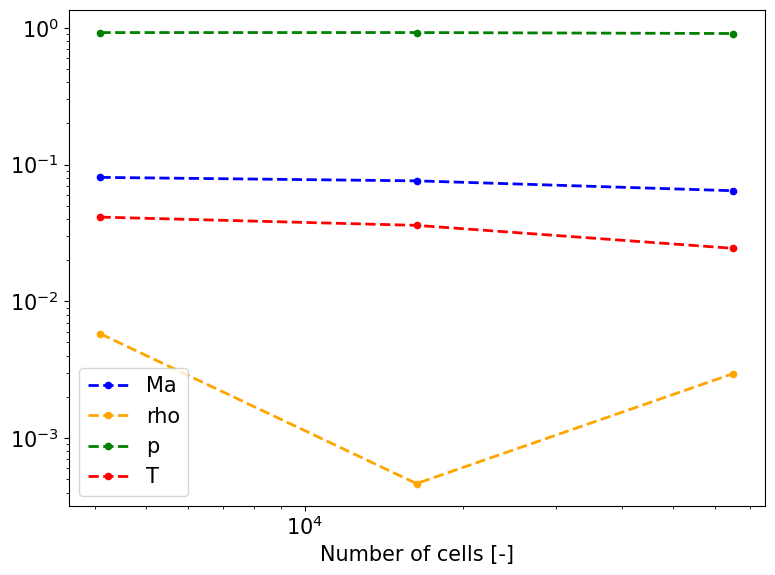

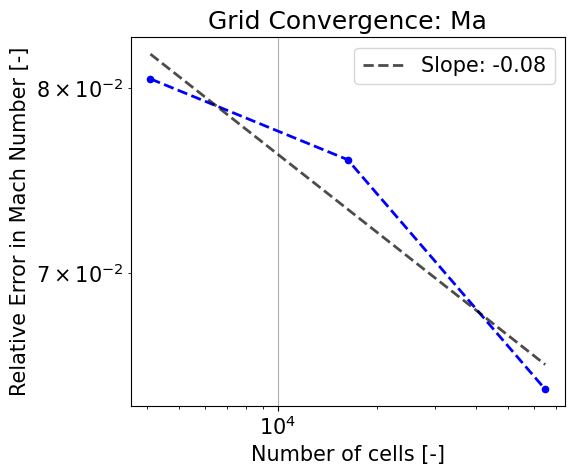

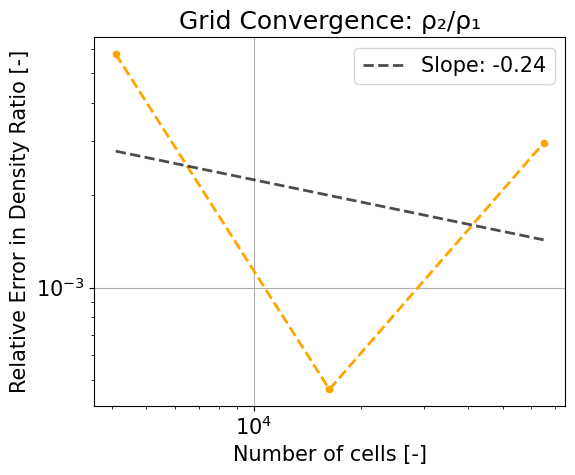

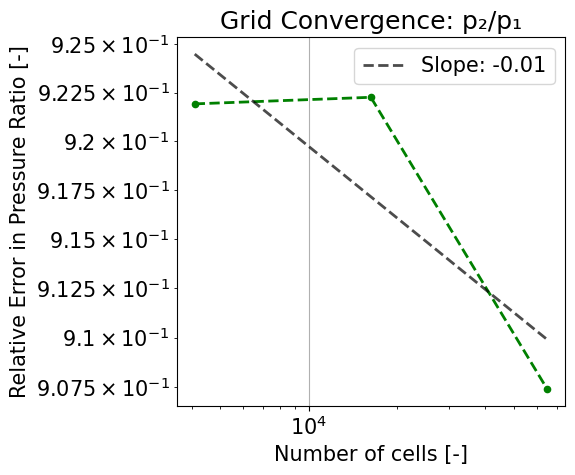

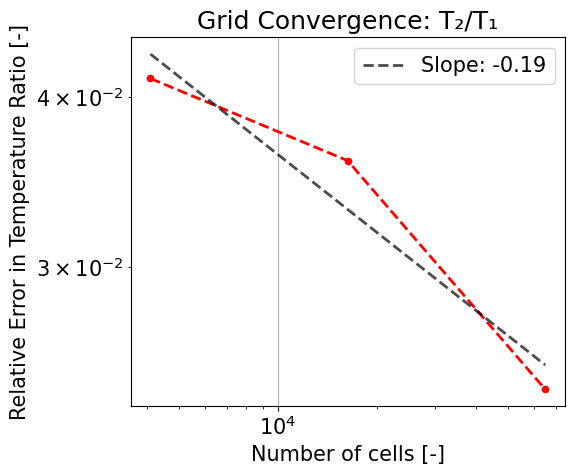

In [ ]:
Ma2, T2, T2T1, p2, p2p1, rho2, rho2rho1 = [], [], [], [], [], [], []
for i, df_ in enumerate(df_convergence):
    Ma2.append(df_['Ma'].values[-1])
    rho2.append(df_['rho'].values[-1])
    rho2rho1.append(df_['rho'].values[-1] / rho1)
    T2.append(df_['T'].values[-1])
    T2T1.append(df_['T'].values[-1] / T1)
    p2.append(df_['p'].values[-1])
    p2p1.append(df_['p'].values[-1] / p1)
Ma2 = np.array(Ma2)
rho2, rho2rho1 = np.array(rho2), np.array(rho2rho1)
T2, T2T1 = np.array(T2), np.array(T2T1)
p2, p2p1 = np.array(p2), np.array(p2p1)
properties_analytical = [ # Ma2, p2/p1, T2/T1
    1.486,
    1.714,
    1.167,
    1.264,
]

error_absolute = [
    np.abs(Ma2 - properties_analytical[0]),  
    np.abs(rho2rho1 - properties_analytical[1]),
    np.abs(p2p1 - properties_analytical[2]),
    np.abs(T2T1 - properties_analytical[3]),
]
error_relative = [
    np.abs(Ma2 - properties_analytical[0]) / properties_analytical[0],
    np.abs(rho2rho1 - properties_analytical[1]) / properties_analytical[1],
    np.abs(p2p1 - properties_analytical[2]) / properties_analytical[2],
    np.abs(T2T1 - properties_analytical[3]) / properties_analytical[3],
]

fig, axs = plt.subplots(figsize=(8, 6), sharex=True)
for i, (err_rel, label, color) in enumerate(zip(error_relative, ['Ma', 'rho', 'p', 'T'], colors)):
    axs.loglog(
        total_cells, err_rel, 
        '--o',
        label=f'{label}', 
        color=color
    )
axs.set_xlabel('Number of cells [-]')
axs.legend()
axs.grid()
fig.tight_layout()
# if savefig is not None:
fig.savefig('Figures/GridConvergence.pdf', bbox_inches='tight')
fig.show()

# Create individual plots for each property
properties_names = ['Mach Number', 'Density Ratio', 'Pressure Ratio', 'Temperature Ratio']
properties_labels = ['Ma', 'ρ₂/ρ₁', 'p₂/p₁', 'T₂/T₁']

for i, (err_rel, prop_name, prop_label, color) in enumerate(zip(error_relative, properties_labels, properties_names, colors)):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.loglog(total_cells, err_rel, '--o', color=color)
    
    # Add a trend line to estimate convergence order
    p = np.polyfit(np.log(total_cells), np.log(err_rel), 1)
    ax.loglog(
        total_cells, np.exp(p[1]) * np.array(total_cells)**p[0], 'k--', alpha=0.7, 
        label=f'Slope: {p[0]:.2f}')
    
    ax.set_xlabel('Number of cells [-]')
    ax.set_ylabel(f'Relative Error in {prop_label} [-]')
    ax.set_title(f'Grid Convergence: {prop_name}')
    ax.legend()
    
    fig.tight_layout()
    fig.show()
    fig.savefig(f'Figures/GridConvergence_{prop_label}.pdf', bbox_inches='tight')
    # plt.close(fig)

## Residuals

In [ ]:
def extract_residuals(case_reader):
    """Extract residual data from a case reader for all properties."""
    # Get the available time steps
    timeSteps = case_reader.TimestepValues
    local_residuals = {}
    
    for prop in properties:
        local_residuals[prop] = {'avg': [], 'min': [], 'max': []}
    
    # Create a render view for the pipeline
    renderView = GetActiveViewOrCreate('RenderView')
    SetActiveSource(case_reader)
    
    # Loop through time steps to extract residual data
    for time in tqdm(timeSteps, desc=f"Processing case"):
        case_reader.UpdatePipeline(time)
        
        # Extract data for each property
        for prop in properties:
            # Get data for the current property at this time step
            dataInfo = case_reader.GetDataInformation().GetPointDataInformation().GetArrayInformation(prop)
            if dataInfo:
                # Extract range values
                range_values = dataInfo.GetComponentRange(0)
                local_residuals[prop]['min'].append(range_values[0])
                local_residuals[prop]['max'].append(range_values[1])
                
                # For average, use a calculator filter
                calculator = Calculator(Input=case_reader)
                calculator.Function = prop
                calculator.ResultArrayName = f"{prop}_value"
                calculator.UpdatePipeline(time)
                calc_data = servermanager.Fetch(calculator)
                
                # Process the data to calculate average
                values = []
                if calc_data.GetNumberOfBlocks() > 0:
                    for i in range(calc_data.GetNumberOfBlocks()):
                        block = calc_data.GetBlock(i)
                        if block and block.GetPointData().GetNumberOfArrays() > 0:
                            data_array = block.GetPointData().GetArray(f"{prop}_value")
                            if data_array:
                                for j in range(data_array.GetNumberOfTuples()):
                                    values.append(data_array.GetValue(j))
                
                avg = sum(values) / len(values) if values else 0
                local_residuals[prop]['avg'].append(avg)
                Delete(calculator)
    
    # Clean up
    Delete(renderView)
    
    return local_residuals

In [ ]:
# # Create structures to store residual data
# residuals = {}
# for prop in properties:
#     residuals[prop] = {'avg': [], 'min': [], 'max': []}

# # Create directory for saving residuals
# os.makedirs('Figures/Residuals', exist_ok=True)

# # Process all cases
# for i, case in enumerate(tqdm(foamCase, desc="Processing cases")):
#     print(f"Extracting residuals for case {i+1}/{len(foamCase)} (angle {angles[i]})")
#     case_residuals = extract_residuals(case)
    
#     # Save residuals to file for each case
#     for prop in properties:
#         for res_type in ['avg', 'min', 'max']:
#             residuals[prop][res_type] = case_residuals[prop][res_type]
    
#     # Save the residuals data to file
#     residual_file = f'Figures/Residuals/angle_{angles[i]}_residuals.npz'
#     np.savez(
#         residual_file, 
#         Ma_avg=case_residuals['Ma']['avg'], Ma_min=case_residuals['Ma']['min'], Ma_max=case_residuals['Ma']['max'],
#         T_avg=case_residuals['T']['avg'], T_min=case_residuals['T']['min'], T_max=case_residuals['T']['max'],
#         p_avg=case_residuals['p']['avg'], p_min=case_residuals['p']['min'], p_max=case_residuals['p']['max'],
#         U_avg=case_residuals['U']['avg'], U_min=case_residuals['U']['min'], U_max=case_residuals['U']['max']
#     )
    
#     # Also create individual plots for each case
#     fig, axs = plt.subplots(len(properties), 1, figsize=(10, 12), sharex=True)
    
#     for j, prop in enumerate(properties):
#         times = np.arange(len(case_residuals[prop]['avg']))
#         axs[j].loglog(times, case_residuals[prop]['avg'], 'b-', label='Average')
#         axs[j].loglog(times, case_residuals[prop]['min'], 'g--', label='Minimum')
#         axs[j].loglog(times, case_residuals[prop]['max'], 'r--', label='Maximum')
#         axs[j].set_ylabel(f'{prop}')
#         axs[j].grid(True)
#         axs[j].legend()
    
#     axs[-1].set_xlabel('Time Step')
#     fig.suptitle(f'Property Residuals Over Time - Angle {angles[i]}')
#     fig.tight_layout()
#     plt.savefig(f'Figures/Residuals/angle_{angles[i]}_residuals.pdf', bbox_inches='tight')
#     plt.close(fig)

: 